# IC 720 Isophot Method

**Set your starting options here:**
* nick: Nickname that will appear in saved files.
* file: Saved and working location.
* datapath: The path from the project (this file) to the data file.
* sci: Location of the science image (index). Typically 0 or 1.
* need_cutout: If the target is very small within the original image, you may want to use a smaller cutout of the image.
* pos,size: if need_cutout=True, then specific approximate center (x,y) of area of interest, and size of desired cutout (px).

(Python 3.12.3)

In [1]:
datapath = 'ic720_data/ic720.fits'  # path to original data
sci = 0                             # science index of data (usually 0)

nick = 'ic720'                     # nickname applied to file names
file = 'ic720_output/ic720'       # saved and working location. Includes the nickname.

pos,size = (2210,3398),(2000, 2000) # position and size of cutout, if needed.

## Imports

In [2]:
from TheOG.utils import *
import TheOG.rotate_tools as rot
import TheOG.isophote_tools as iso

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import SigmaClip # class
from astropy.stats import sigma_clip
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.visualization import ZScaleInterval

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from photutils.background import Background2D, MedianBackground

%load_ext autoreload
%autoreload 2

## Setup
Open and view the data file.

Filename: ic720_data/ic720.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     357   (4220, 4300)   float32   
None
image is 2D.


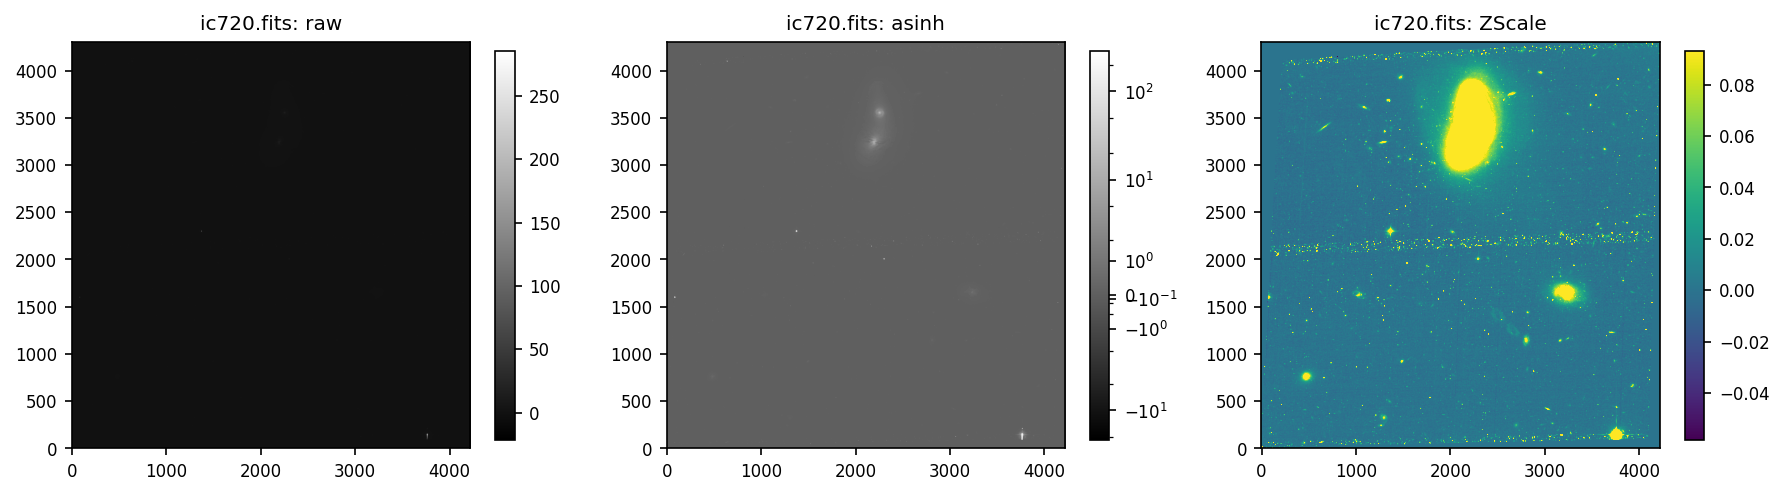

In [3]:
hdulist0, image_data0, prihdr0 = quick_open(datapath, sci)

In [4]:
hdulist, image_data, prihdr = create_working_file(path=datapath, sci=sci, file=file, cutout=True, pos=pos, size=size)

Filename: ic720_data/ic720.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     357   (4220, 4300)   float32   
None
image is 2D.
Cannot make a smaller cutout. Perhaps it already exists, and is being used by another process.
If a new cutout is desired, close ds9 and restart kernal to update.
Continuing to next step, using previous cutout if available...
data shape: (1902, 2000)


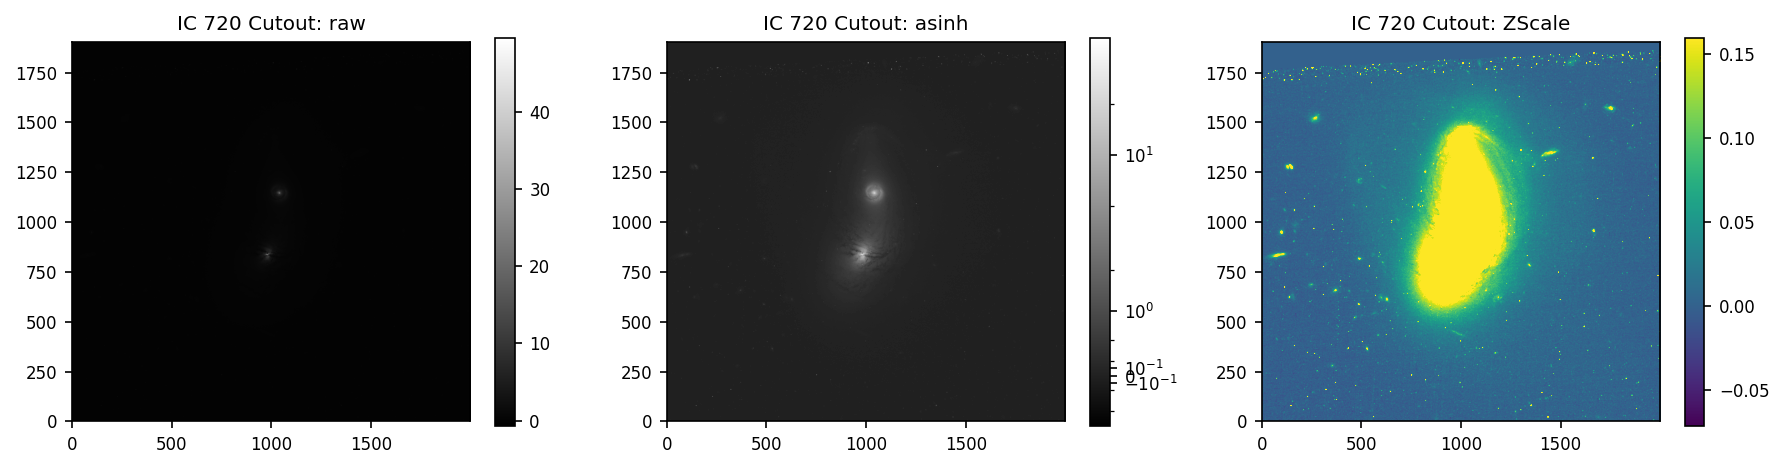

In [5]:
quick_plot(image_data, name='IC 720 Cutout')

## Apertures

In [6]:
drawregions(fitsfile=file+'.fits', science=sci)

data shape:	 (1902, 2000)

Please open DS9 with the newly generated .reg file and move
the x to the forground galaxy center, 
the + to the background galaxy center, 
the blue ellipse to encompass the foreground galaxy, and
the red ellipse to encompass the background galaxy.

WHEN SAVING, OPT FOR IMAGE so everything is in PIXELS for TheOG to deal with.
Best practice is to make a separate .reg file in WCS.


In [7]:
x0_fg,y0_fg,a_fg,b_fg,pa_fg, x0_bg,y0_bg,a_bg,b_bg,pa_bg  = readregion(file+'_regions.reg')

#defining aperture collections:
aper_fg = (x0_fg,y0_fg,a_fg,b_fg,pa_fg)
aper_bg = (x0_bg,y0_bg,a_bg,b_bg,pa_bg)
print(aper_fg)
print(aper_bg)

# Region file format: DS9 version 4.1

global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1

image

point(981.40924,835.05118) # point=x 15 color=red text={BG center}

Found the background galaxy center marker!
981.40924 835.05118
point(1038.2624,1144.9215) # point=cross 15 color=blue text={FG center}

Found the foreground galaxy center marker!
1038.2624 1144.9215
ellipse(1038.2621,1144.9129,463.08712,302.73788,89.999997) # color=blue

Found the foreground galaxy ellipse!
1038.2621 1144.9129 463.08712 302.73788 89.999997 

ellipse(981.41331,835.04407,280.54421,395.16782,338.81011) # color=red

Found the background galaxy ellipse!
981.41331 835.04407 280.54421 395.16782 338.81011 

(1038.2624, 1144.9215, 463.08712, 302.73788, 89.999997)
(981.40924, 835.05118, 280.54421, 395.16782, 338.81011)


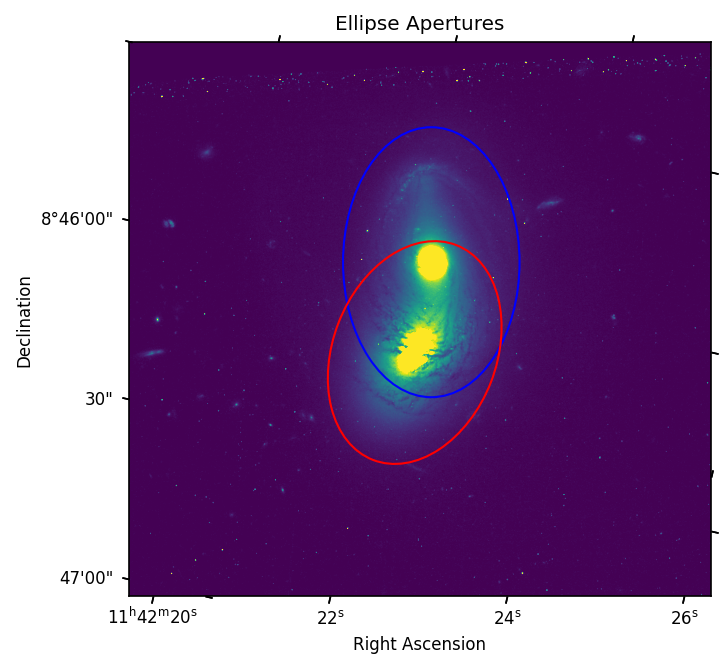

In [8]:
plot_ellipses(image_data, prihdr, aper_fg, aper_bg, figname=file+'_elip_aper.png', ZScale=False, label=False) #labels positions are currently set in Image_tools

## Isophote Method

In [9]:
help(iso)

Help on module TheOG.isophote_tools in TheOG:

NAME
    TheOG.isophote_tools

DESCRIPTION
    This module contains all functions needed to analyze overlapping galaxies using the isophote technique.
    The module utils contains most other imports, and access to utility functions.

FUNCTIONS
    fit_isophote(data, aper, use_mask=False, firstgood=True, isotablefile='')
        Fit an isophote within the elliptical aperture provided.
        Use the mask to include/exclude pixels in that aperture.
        Firstgood means that the routine will go with the first modified aperture
        that provides a meaningful isophotal fit.

        Follows this tutorial: https://photutils.readthedocs.io/en/latest/user_guide/isophote.html

        Parameters:
            data : numpy array
                Two-dimensional image data

            header : fits header
                The header information to go with the data.

            aperture : elliptical aperture
                aperture used in th

### Without Mask

In [10]:
isolist_fg, geometry_fg, aperture_fg, new_data = iso.fit_isophote(image_data, aper_fg)
# isolist_bg, geometry_bg, aperture_bg = iso.fit_isophote(image_data, prihdr, aper_bg)

data shape:	(1902, 2000)
apply mask?
No mask applied
Using size factor  1.0 on the aperture
geometry:	<photutils.isophote.geometry.EllipseGeometry object at 0x000001CD5F1C7DA0>,	geometry.pa:	1.5707962744350188
ellipse:	<photutils.isophote.ellipse.Ellipse object at 0x000001CD5F1C4BF0>,	ellipse pa:	1.5707962744350188
isolist:	<photutils.isophote.isophote.IsophoteList object at 0x000001CD5F2B5CD0>,	length:	79
ok a size size factor of  1.0 on the aperture seems to work.
Isophote fit not saved to a file.
Using size factor  1.1 on the aperture
geometry:	<photutils.isophote.geometry.EllipseGeometry object at 0x000001CD5F1C7260>,	geometry.pa:	1.5707962744350188
ellipse:	<photutils.isophote.ellipse.Ellipse object at 0x000001CD5F2B7350>,	ellipse pa:	1.5707962744350188


c:\Users\dogfi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dogfi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dogfi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dogfi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\dogfi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

isolist:	<photutils.isophote.isophote.IsophoteList object at 0x000001CD5F2B46B0>,	length:	80
ok a size size factor of  1.1 on the aperture seems to work.
Isophote fit not saved to a file.


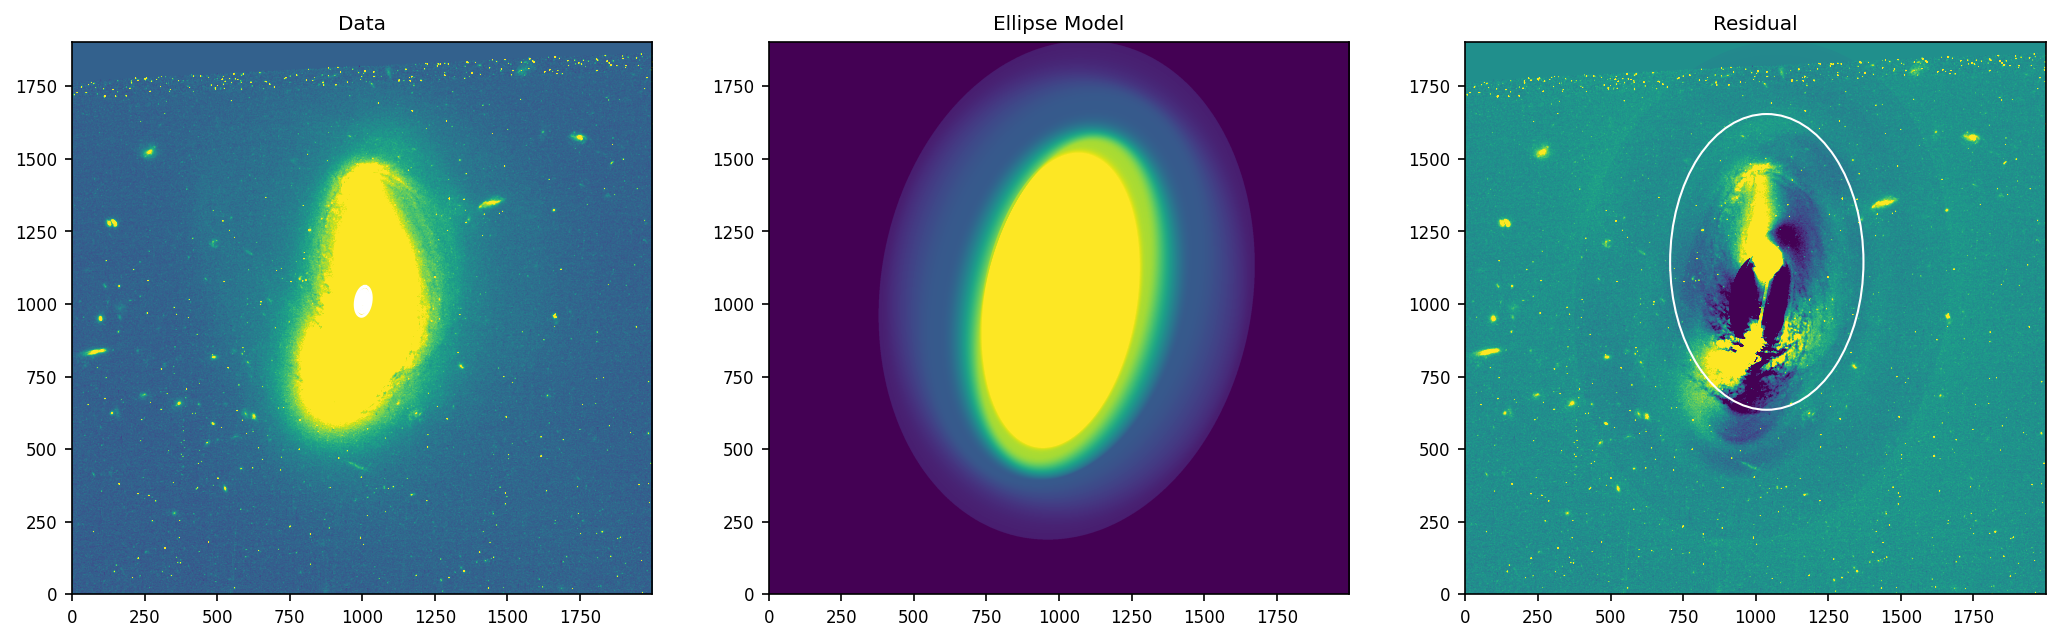

<Figure size 960x720 with 0 Axes>

In [11]:
model_image = iso.plot_isophote(new_data, isolist_fg, aperture_fg, file)
# iso.plot_isophote(image_data, prihdr, isolist_bg, aperture_bg, file)

### With Mask

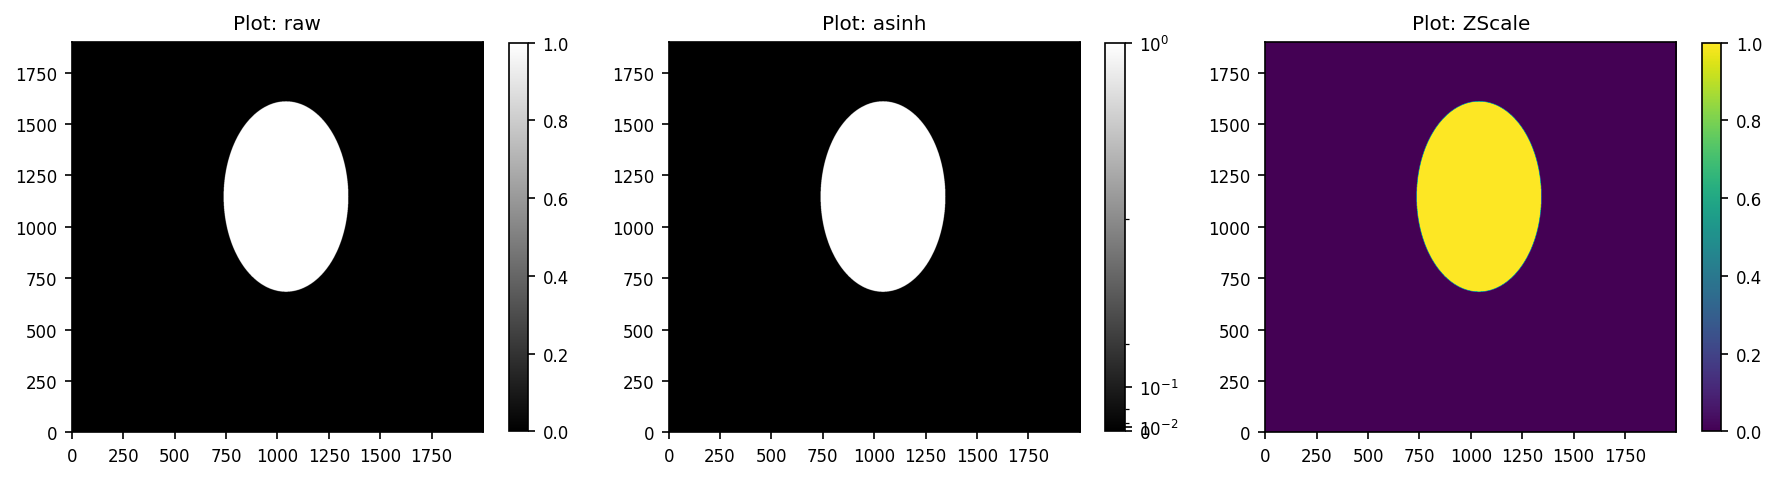

In [12]:
mask = make_ellipse_mask(image_data, aper_fg)
quick_plot(mask)

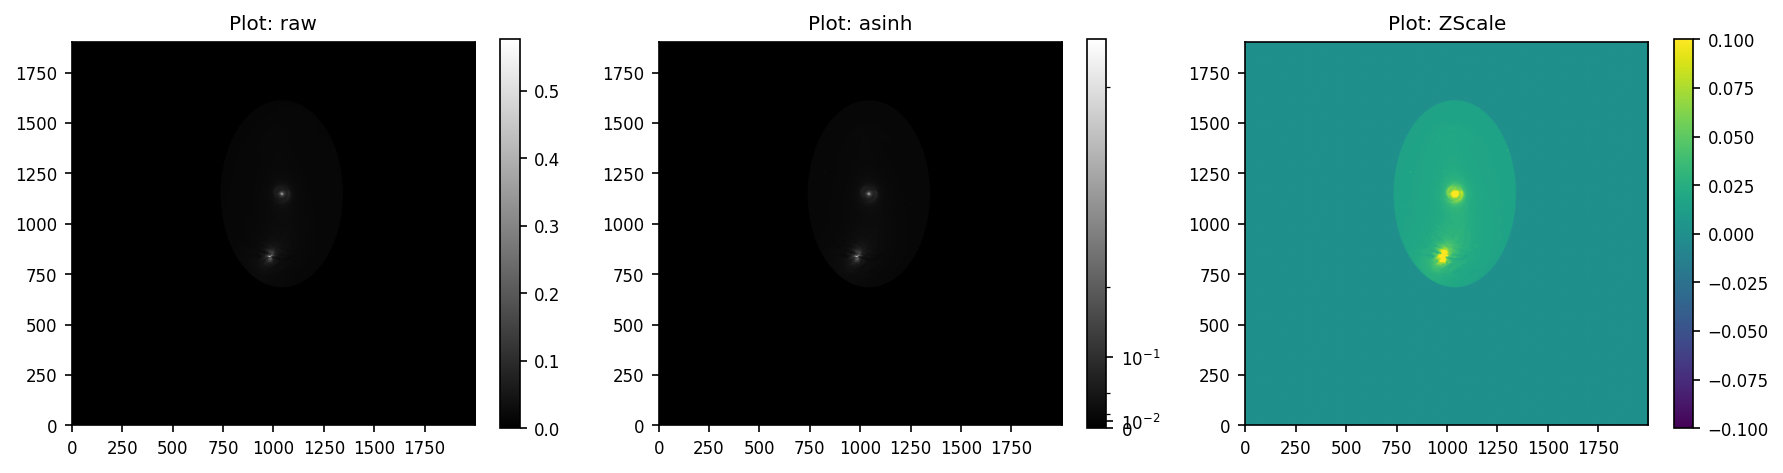

In [13]:
masked_fg = apply_mask(image_data, aper_fg)
quick_plot(masked_fg)

In [14]:
isolist_fg, geometry_fg, aperture_fg, masked_data = iso.fit_isophote(image_data, prihdr, aper_fg, 
                                                                     use_mask=True,
                                                                    #  mask=masked_fg
                                                                     )

TypeError: fit_isophote() got multiple values for argument 'use_mask'

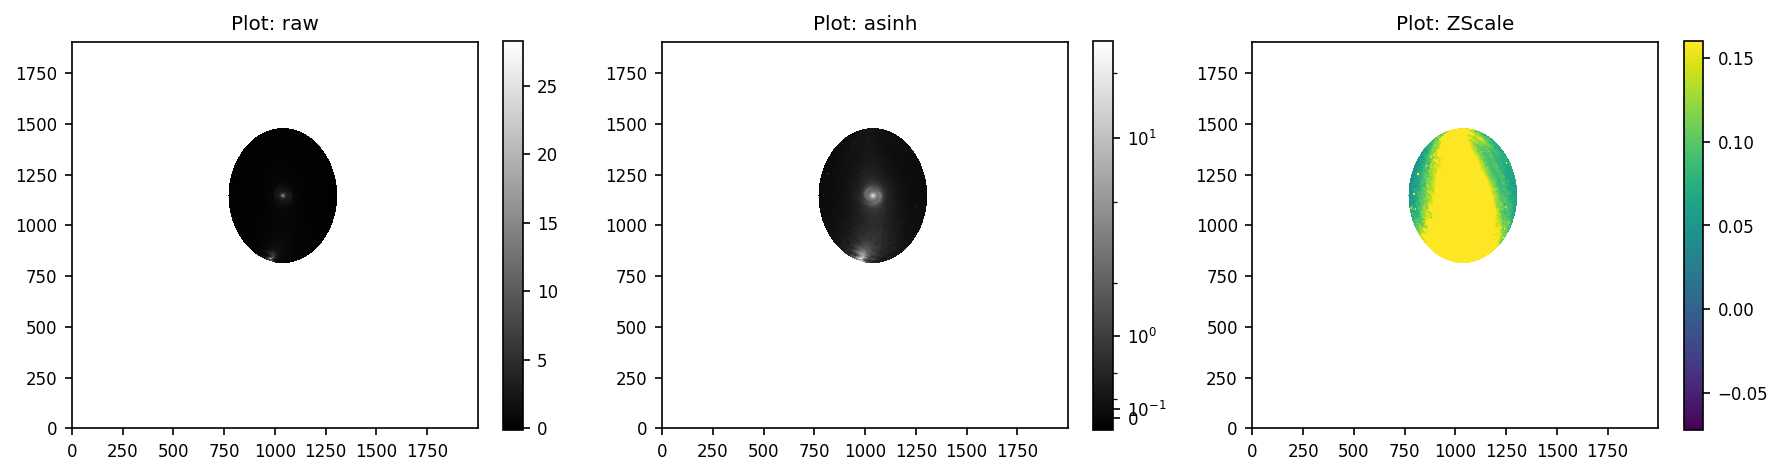

In [ ]:
quick_plot(test_data)

In [ ]:
print(isolist_fg.to_table())

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0   27.301176098330874 ...     0         0
0.5174364656700751   27.213488041470004 ...    10         0
0.5691801122370826   27.197893254515726 ...    22         0
 0.626098123460791   27.148806040390827 ...    21         0
0.6887079358068701   27.055642890796207 ...    18         0
0.7575787293875571   26.935384706628387 ...    17         0
0.8333366023263128   26.819062565612107 ...    11         0
0.9166702625589441   26.714761962477912 ...    10         0
1.0083372888148385    26.59535868371362 ...    10         0
               ...                  ... ...   ...       ...
 408.6438741000001  0.15784707973986722 ...    50         2
 449.5082615100002   0.1327349044011388 ...    10         0
494.45908766100024  0.11921692794383631 ...    10         0
 543.9049964271003  0.06496375060642126 

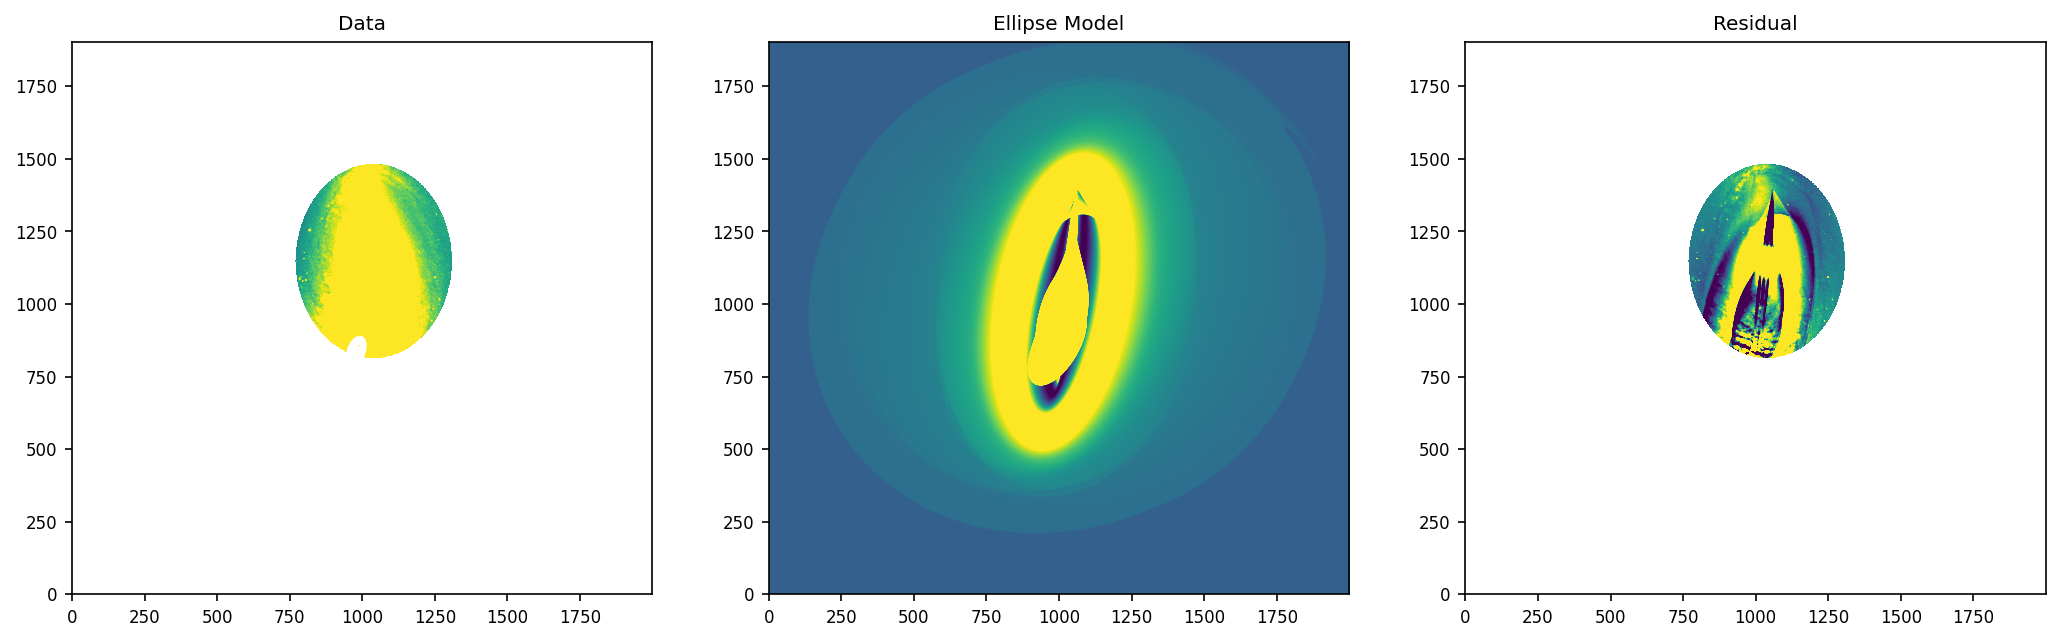

<Figure size 960x720 with 0 Axes>

In [ ]:
model_image = iso.plot_isophote(test_data, prihdr, isolist_fg, aperture_fg, file)

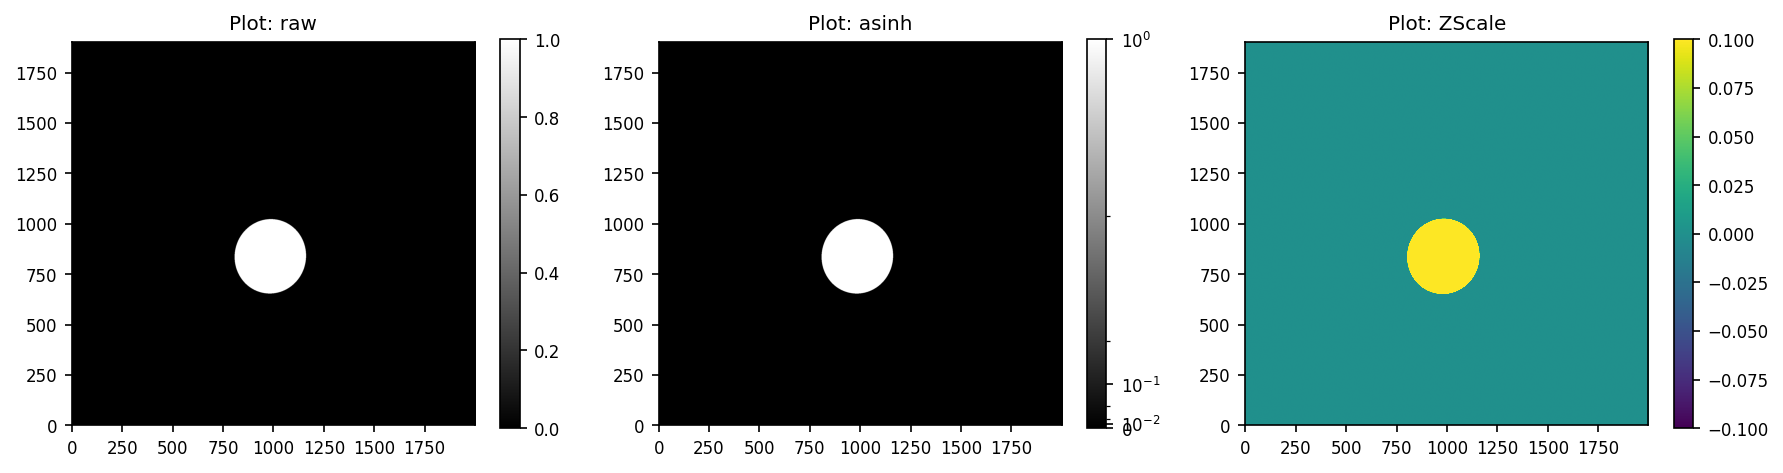

In [ ]:
mask=make_ellipse_mask(image_data, aper_bg)
quick_plot(mask)

In [ ]:
isolist_fg, geometry_fg, aperture_fg = iso.fit_isophote(image_data, prihdr, aper_fg, mask=mask)
iso.plot_isophote(image_data, prihdr, isolist_fg, aperture_fg, file)

TypeError: fit_isophote() got an unexpected keyword argument 'mask'

In [ ]:
# iso.plot_isofit(isolist=isolist_fg)
# iso.plot_isofit(isolist=isolist_bg)